In [45]:
# Check if running in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  

In [46]:
if IN_COLAB :
    # If we are in colab we don't have access to our custom modules so we clone the repository
    !git clone https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor.git
    # Pull last data from git
    !cd clothes-extractor && git pull && cd ..


In [47]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [48]:
if IN_COLAB :
  # Import code form our github
  from pathlib import Path

  current_folder = globals()['_dh'][0]
  parent = Path(current_folder).parent
  os.chdir(os.path.join(current_folder, "clothes-extractor"))
  print(os.getcwd())
  
# Project imports
from dataset.dataset import ClothesDataLoader, ClothesDataset
from config import Config
from models.unet import Unet
from trainer.trainer import train_model

In [49]:
seed = 22
torch.manual_seed(seed)
torch.torch.cuda.manual_seed_all(seed)
torch.mps.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built() and torch.device != "cuda":
  device = torch.device("mps")
print(device)

mps


In [51]:
# Type here the path for the data set
dataset_path = os.path.join("data", "zalando-hd-resized")
!pwd

# Dowload the dataset only if it does not exist
if (os.path.exists(dataset_path)):
  print("Dataset already downloaded")
else:
  print("Dowloading dataset")
  os.makedirs(dataset_path, exist_ok=True)
  path_components = dataset_path.split(os.path.sep)
  new_path = os.path.sep.join(path_components[:-1])
  with open("path_check.tmp", 'w') as file:
    file.write(new_path)
  !wget https://www.dropbox.com/s/10bfat0kg4si1bu/zalando-hd-resized.zip
  !echo "Extracting the dataset. Please wait...."
  !unzip zalando-hd-resized.zip -d `cat path_check.tmp` > /dev/null
  !rm path_check.tmp
  !rm zalando-hd-resized.zip
  print("Done")

/Users/acabanas/dev/forks/clothes-extractor/Jupyters
Dataset already downloaded


In [52]:
cfg = Config()
cfg.batch_size = 10
cfg.dataset_dir = dataset_path
cfg.load_height = 28
cfg.load_width = 28
cfg.learning_rate = 0.0002
cfg.num_epochs = 1
cfg.num_val_samples = 10
cfg.num_input_channels = 1

In [53]:

test_dataset = ClothesDataset(cfg, "test")
train_dataset = ClothesDataset(cfg, "train")

test_dataloader = ClothesDataLoader(test_dataset, cfg.batch_size, num_workers=cfg.workers)
train_dataloader = ClothesDataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=cfg.workers)

Loading image: 07121_00.jpg 1557
Loading image: 04376_00.jpg 821
Loading image: 02259_00.jpg 717
Loading image: 04395_00.jpg 388
Loading image: 01872_00.jpg 880
Loading image: 02928_00.jpg 557
Loading image: 00428_00.jpg 1900
Loading image: 06831_00.jpg 1942
Loading image: 01527_00.jpg 938
Loading image: 09251_00.jpg 602
Loading image: 08217_00.jpg 1235
Loading image: 11122_00.jpg 1193
Loading image: 06664_00.jpg 326
Loading image: 08566_00.jpg 1645
Loading image: 08871_00.jpg 1697
Loading image: 12749_00.jpg 1194
Loading image: 03392_00.jpg 190
Loading image: 05980_00.jpg 268
Loading image: 14450_00.jpg 1614
Loading image: 08930_00.jpg 1795


/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loading image: 10040_00.jpg 4217
Loading image: 03638_00.jpg 1889
Loading image: 10622_00.jpg 7347
Loading image: 04954_00.jpg 7827
Loading image: 06187_00.jpg 10340
Loading image: 10619_00.jpg 9144
Loading image: 10522_00.jpg 7551
Loading image: 13452_00.jpg 7945
Loading image: 03770_00.jpg 2525
Loading image: 08631_00.jpg 3013
Loading image: 12295_00.jpg 6755
Loading image: 14390_00.jpg 8733
Loading image: 03220_00.jpg 9081
Loading image: 10953_00.jpg 3693
Loading image: 04747_00.jpg 2749
Loading image: 09850_00.jpg 9798
Loading image: 13390_00.jpg 1775
Loading image: 12068_00.jpg 10573
Loading image: 10002_00.jpg 8762
Loading image: 09834_00.jpg 4807


/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loading image: 08020_00.jpg 2


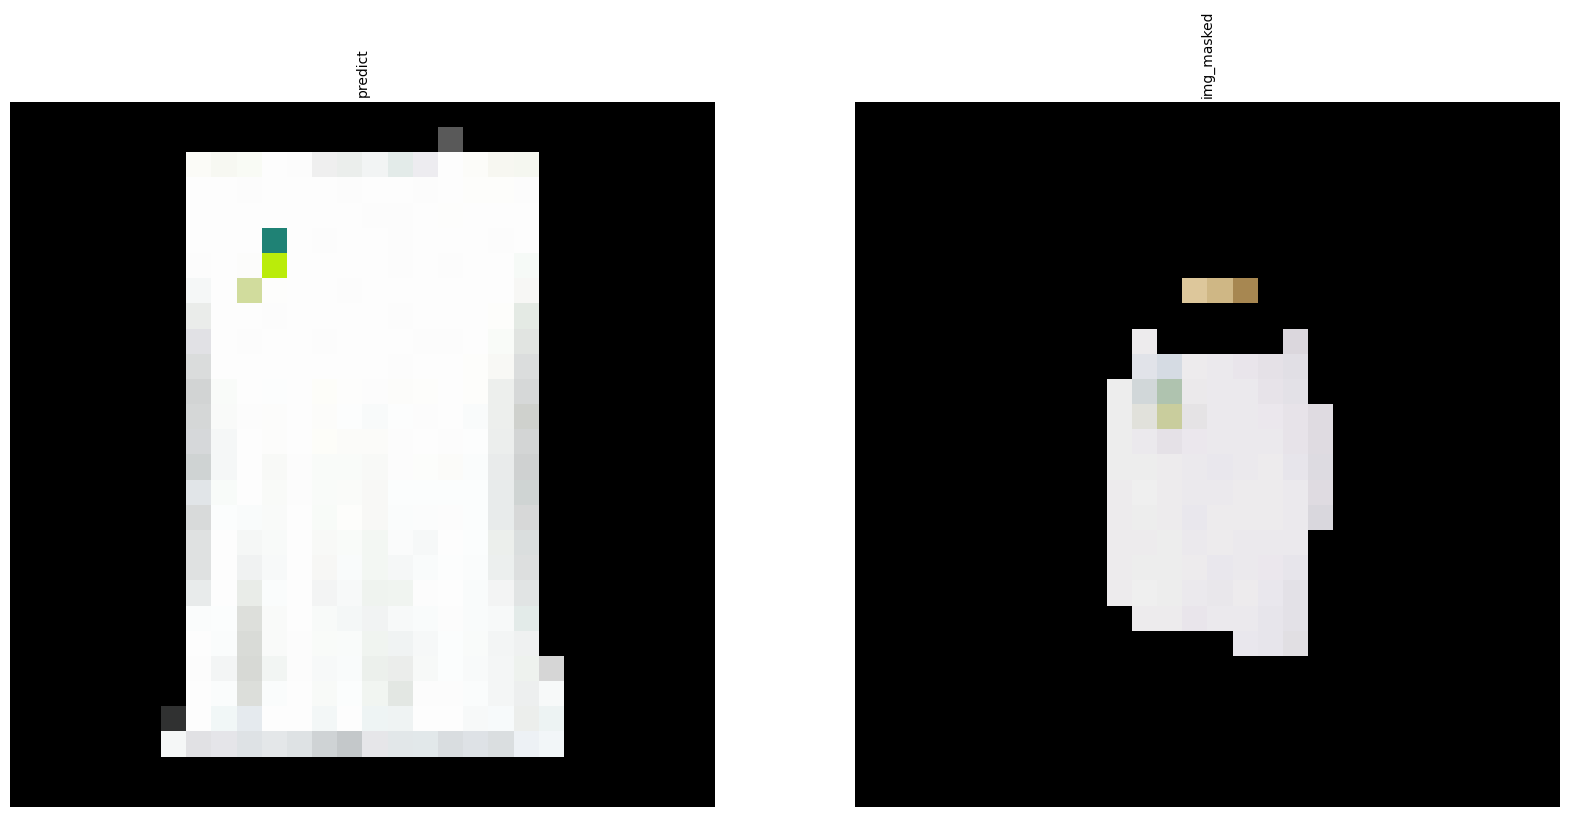

In [54]:
image = train_dataset[2]

# image_keys = ["img", "cloth", "cloth_mask", "predict", "agnostic_mask", "mask_body_parts", "mask_body", "centered_mask_body", "img_masked"]
image_keys = ["predict", "img_masked"]
fig, axes = plt.subplots(1, len(image_keys), figsize=(20, 20))

for ax, key in zip(axes, image_keys):
    ax.imshow(image[key].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(key, rotation=90, fontsize=10)

# Defining the UNET
![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

We are using the Unet defined in the [Model module from the repository](https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor/blob/main/src/model.py)

In [55]:

def visualize_nn_output(output, device, image_index=0):
    output = output[image_index].squeeze().detach().cpu().numpy()

    if output.shape[0] in [3, 4]:  # RGB or RGBA
        output = np.transpose(output, (1, 2, 0))

    plt.imshow(output)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


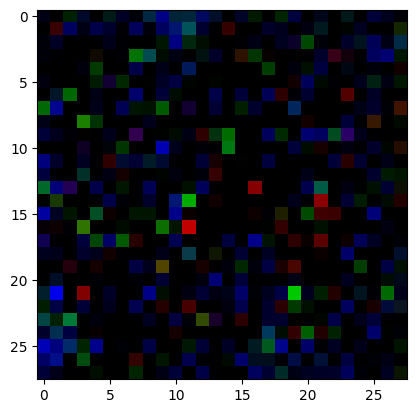

In [56]:
model = Unet(in_channels=3, n_feat=32).to(device)

inp = torch.randn(2,3,28,28).to(device) #As a sanity check, we define a random tensor with the same shape as an input image, to make sure that we can forward it to our network
out = model(inp)

visualize_nn_output(out, device)

The Train model function is the defined in the [train module from the project](https://github.com/aidl-upc-2024-clothes-extractor/clothes-extractor/blob/main/src/train.py)


In [57]:
def run_model_on_image(model, device, dataset, image_index):
    model.eval()
    
    image = dataset[image_index]
    image = image["img_masked"].to(device).unsqueeze(0)

    
    with torch.no_grad():
        output = model(image)

    return output


In [58]:
# For testing purposes (There are so many images) we can limit the number of loaded batches, 0 is no limit
cfg.max_batches = 1

trained_model = train_model(model, device, train_dataloader, test_dataloader, cfg.num_epochs, cfg.learning_rate, cfg.max_batches)


Start training


/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loading image: 07682_00.jpg 2566
Loading image: 01340_00.jpg 11494
Loading image: 12332_00.jpg 3398
Loading image: 00542_00.jpg 9470
Loading image: 06205_00.jpg 2996
Loading image: 03800_00.jpg 5468
Loading image: 00699_00.jpg 9751
Loading image: 00534_00.jpg 280
Loading image: 13680_00.jpg 11432
Loading image: 03477_00.jpg 2915
Loading image: 07881_00.jpg 2581
Loading image: 05799_00.jpg 11177
Loading image: 10767_00.jpg 7568
Loading image: 02762_00.jpg 8195
Loading image: 03147_00.jpg 2594
Loading image: 08749_00.jpg 1141
Loading image: 01135_00.jpg 9616
Loading image: 05347_00.jpg 8274
Loading image: 10221_00.jpg 8522
Loading image: 11306_00.jpg 1237
Loading image: 10514_00.jpg 3984
Loading image: 14522_00.jpg 10210
Loading image: 04195_00.jpg 788
Loading image: 05770_00.jpg 10348
Loading image: 12214_00.jpg 5848
Loading image: 14148_00.jpg 3726
Loading image: 11846_00.jpg 3171
Loading image: 04782_00.jpg 7625
Loading image: 06056_00.jpg 8674
Loading image: 03761_00.jpg 6398


/Users/acabanas/miniconda3/envs/clothes-extractor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loading image: 05325_00.jpg 1122
Loading image: 07627_00.jpg 1875
Loading image: 00075_00.jpg 1954
Loading image: 06730_00.jpg 1178
Loading image: 06154_00.jpg 1139
Loading image: 03601_00.jpg 1300
Loading image: 12736_00.jpg 61
Loading image: 10968_00.jpg 1079
Loading image: 09266_00.jpg 1839
Loading image: 07449_00.jpg 1721
Loading image: 14384_00.jpg 521
Loading image: 04335_00.jpg 1439
Loading image: 12813_00.jpg 1857
Loading image: 11504_00.jpg 50
Loading image: 06441_00.jpg 371
Loading image: 03244_00.jpg 340
Loading image: 09290_00.jpg 69
Loading image: 03969_00.jpg 892
Loading image: 02619_00.jpg 638
Loading image: 13109_00.jpg 119
Loading image: 04298_00.jpg 1904
Loading image: 04672_00.jpg 1501
Loading image: 03639_00.jpg 548
Loading image: 02507_00.jpg 585
Loading image: 07796_00.jpg 630
Loading image: 08989_00.jpg 1093
Loading image: 02180_00.jpg 1061
Loading image: 05205_00.jpg 542
Loading image: 00484_00.jpg 295
Loading image: 14188_00.jpg 336
Epoch [1/1], Train Loss: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loading image: 10224_00.jpg 0


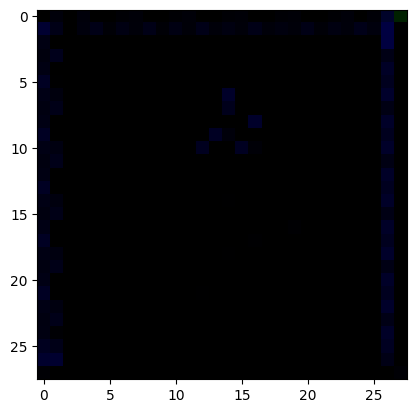

In [59]:
out = run_model_on_image(trained_model, device, train_dataset, 0)
visualize_nn_output(out, device)

In [60]:
import src.dataset as dataset
import importlib
importlib.reload(dataset)

<module 'src.dataset' from '/Users/acabanas/dev/forks/clothes-extractor/src/dataset.py'>